# Assignment-2

**Due Date:** 16.11.2022 

---------------------------------------

**Instructor:** Erkut Erdem

**TA:** Sibel Kapan

---------------------------------------

**Student:** Emre Çoban

**Student ID:** 2200765028


**Github Classroom:** https://classroom.github.com/a/G-DSs1pj



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re
import imageio as iio

## Part I: Theory Questions

### MLE Questions

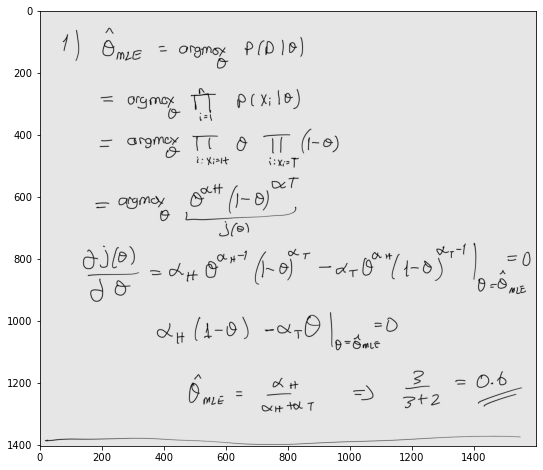

In [23]:
q1 = iio.imread("question1.jpg")
plt.figure(figsize=(12,8))
plt.imshow(q1);

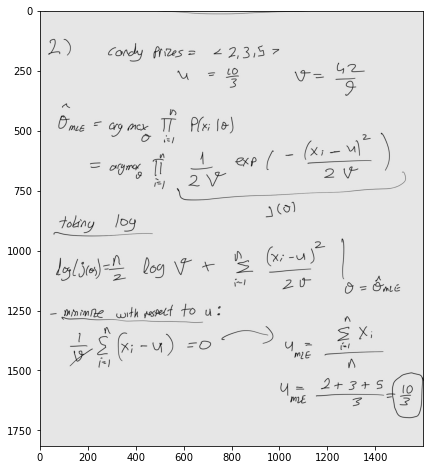

In [24]:
q2 = iio.imread("question2.jpg")
plt.figure(figsize=(12,8))
plt.imshow(q2);

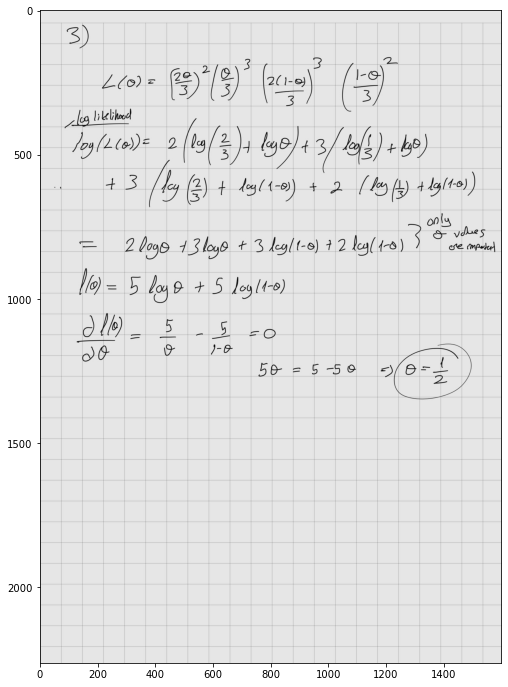

In [25]:
q3 = iio.imread("question3.jpg")
plt.figure(figsize=(16,12))
plt.imshow(q3);

### Naive Bayes question

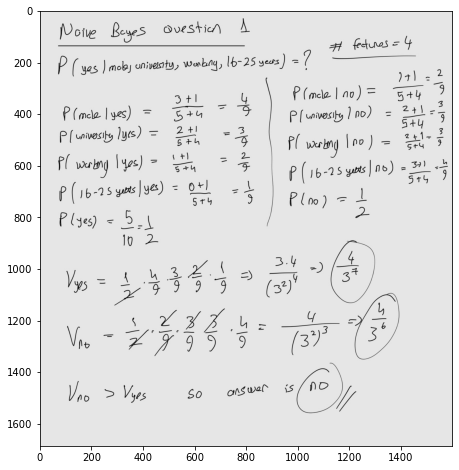

In [26]:
nb_question = iio.imread("naive_bayes_question.jpg")
plt.figure(figsize=(12,8))
plt.imshow(nb_question);

## Part II: Book Genre Classification with Naive Bayes


### Dataset Upload

Dataset uploaded from Drive or local

In [27]:
df = pd.read_csv("./book_dataset_a2.csv",sep='\t')

In [28]:
df.head()

,title,author,description,coverImg,genre
0,The Hunger Games,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,https://i.gr-assets.com/images/S/compressed.ph...,Young Adult
1,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",There is a door at the end of a silent corrido...,https://i.gr-assets.com/images/S/compressed.ph...,Fantasy
2,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,https://i.gr-assets.com/images/S/compressed.ph...,Classics
3,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",Alternate cover edition of ISBN 9780679783268S...,https://i.gr-assets.com/images/S/compressed.ph...,Classics
4,Twilight,Stephenie Meyer,About three things I was absolutely positive.\...,https://i.gr-assets.com/images/S/compressed.ph...,Young Adult


## Part 2.1 Understanding Data

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21079 entries, 0 to 21078
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        21079 non-null  object
 1   author       21079 non-null  object
 2   description  21079 non-null  object
 3   coverImg     21079 non-null  object
 4   genre        21079 non-null  object
dtypes: object(5)
memory usage: 823.5+ KB


In [30]:
df.describe()

,title,author,description,coverImg,genre
count,21079,21079,21079,21079,21079
unique,20113,9984,21038,21061,10
top,Legacy,Nora Roberts (Goodreads Author),This scarce antiquarian book is a facsimile re...,https://i.gr-assets.com/images/S/compressed.ph...,Fiction
freq,9,84,6,2,4856


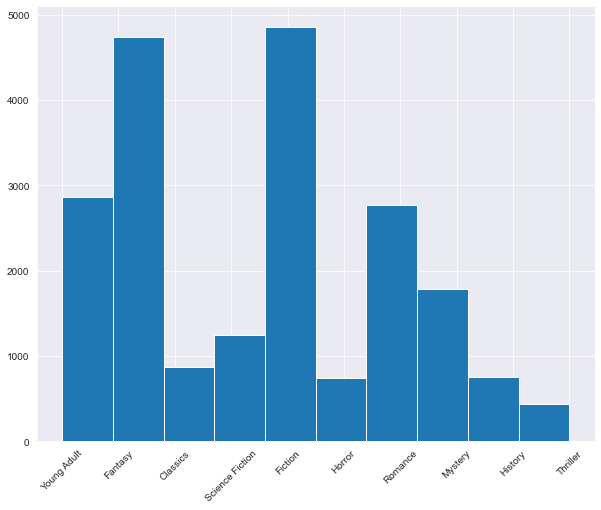

In [31]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))
df["genre"].hist()
plt.xticks(rotation=45);

We have mostly fantasy ,fiction and romance novels as we can see

In [32]:
examples = df[df["genre"]=="Fantasy"]["description"]  ## descriptions for only fantasy

### Lets try to use count vectorize to see most used words 

In [33]:
count = CountVectorizer(stop_words="english") ## I will not include stop words for this one
example_table = count.fit_transform(examples).toarray()

In [34]:
word2i = count.vocabulary_
i2word = {k:v for v,k in word2i.items()}

In [35]:
example_table = example_table.sum(axis=0)

In [36]:
print("10 words whose presence most strongly predicts the ","Fantasy")
indices = example_table
dct = {k: i2word[v] for v, k in enumerate(indices)}
dct =sorted(dct.items(), key=lambda dct: dct[0],reverse=True)
dct = dict(dct)
dct = list(dct.values())
print(dct[:10],"\n")



10 words whose presence most strongly predicts the  Fantasy
['world', 'new', 'life', 'magic', 'time', 'power', 'old', 'book', 'dark', 'love'] 



## As we can see these are meaningful words for fantasy genre,
## We can definitely identify genres with given words

### my guess for 3 example of specific words to identify genre of a book
#### dragon => Fantasy
#### love => Young Adult
#### story => Classics
#### vampire => fantasy
### if a word occurs more this means it will have more to say than others

## Part 2.2 Implementing Naive Bayes Algorithm

### !! Be Careful Accuracy might depend on laplacian smoothing constant when creating model !!

In [37]:
class NaiveBayes():
    
    def __init__(self,alpha = 1): ## constant for laplacian smoothing
        
        self.alpha = alpha
    
    def train(self,X,y_tr,vocab,word2i,class_names):  ## X should be vectorized before and y should be encoded
        
          
        self.vocab = vocab
        
        self.word2i = word2i ## so we can access index of words
        
        self.labels = np.unique(y_tr) ##[0,1,2,3,4,5,6,7,8,9]
        
        self.n_classes = len(self.labels)

        
        self.class_names = class_names
        
        self.name2i = {}
        i = 0
        for name in self.class_names:
            self.name2i[name] = i
            i+=1
            
        self.P_y =  np.zeros(self.n_classes)
        
        for i in y_tr:
            self.P_y[i] +=1

        self.log_p_y = np.log(self.P_y/len(y_tr)) ## changing to log prior
   

        self.count_per_label =np.zeros((len(self.labels),len(self.vocab))) ## (n_classes x n_features) 

        for i in range(X.shape[0]): ## for each label we count how many occurences each word has in that label
    
            label = y_tr[i]
            self.count_per_label[label] += X[i]
            
        
    def predict(self,X_test):
        predicted = []
    
        for text in tqdm(X_test):
    
            self.posteriors = {label: self.log_p_y[label] for label in self.labels}
        
            for word in text.split():
                
                for label in self.labels:
                    
                    log_x_y = self.laplacian(word,label)
                    self.posteriors[label] += log_x_y # Since we used log probs the formula is just addition instead of mult.
                 
            label_with_max_prob = max(zip(self.posteriors.values(), self.posteriors.keys()))[1]
            predicted.append(label_with_max_prob)

        return predicted
    
   
    
    
    def laplacian(self,current_word, label):

        try : 
            p_x_y = self.count_per_label[label,self.word2i[current_word]] + self.alpha ## I found out that instead of alpha = 1 , 0.1 is better
   
        except KeyError:
            p_x_y = self.alpha ## never seen word
        
        finally :
        
            p_y = self.P_y[label] + self.alpha*len(self.vocab)
    
            log_x_y = np.log(p_x_y/p_y)
        return log_x_y

### Data Preprocessing for our model

In [38]:
def preprocess_text(text): ## preprocess to remove digits from description
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

In [39]:
X = df["description"]
y = df["genre"]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(y)
class_names = encoder.classes_

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels,stratify=encoded_labels, test_size=0.2,random_state=42 )

In [41]:
name2i = {} ## later on this dict might be useful
i = 0
for name in encoder.classes_:
    name2i[name] = i
    i+=1
name2i

{'Classics': 0,
 'Fantasy': 1,
 'Fiction': 2,
 'History': 3,
 'Horror': 4,
 'Mystery': 5,
 'Romance': 6,
 'Science Fiction': 7,
 'Thriller': 8,
 'Young Adult': 9}

In [21]:
countVec = CountVectorizer(preprocessor = preprocess_text)
X_train_uni = countVec.fit_transform(X_train).toarray()
vocab = countVec.get_feature_names_out()
word2i = countVec.vocabulary_ ## so we can access index of words

In [22]:
model  = NaiveBayes(alpha=0.1)  ## I found out that alpha=0.1 is better smoothing

In [23]:
model.train(X_train_uni,y_train,vocab,word2i,class_names)

In [24]:
results = model.predict(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:22<00:00, 187.12it/s]


In [25]:
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),5)))

Accuracy  % 47.913


In [26]:
print("Occurence of 'dragon' in classics ",model.count_per_label[:,word2i["dragon"]][name2i["Classics"]])  
print("Occurence of 'love' in classics ",model.count_per_label[:,word2i["love"]][name2i["Classics"]])

## as we can see we are getting how many occurences does a word have in that genre from count_per_label table

Occurence of 'dragon' in classics  3.0
Occurence of 'love' in classics  196.0


### Trying for bigram model

In [36]:
countVec = CountVectorizer(preprocessor = preprocess_text,ngram_range=(2,2))
X_train_bi = countVec.fit_transform(X_train)
vocab = countVec.get_feature_names_out()
word2i = countVec.vocabulary_ ## so we can access index of words

In [37]:
model  = NaiveBayes(alpha=1)  ## I will try 1 for bigram

### Since taking all of the data gives memory allocating error I decided to some part of them for bigram model.


In [38]:
model.train(X_train_bi[:5000].toarray(),y_train[:5000],vocab,word2i,class_names)

In [39]:
results = model.predict(X_test)
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),5)))

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:23<00:00, 176.78it/s]


Accuracy  % 22.509


## Now I will try bigram without stopwords

In [32]:
countVec = CountVectorizer(preprocessor = preprocess_text,ngram_range=(2,2),stop_words="english")
X_train_bi = countVec.fit_transform(X_train)
vocab = countVec.get_feature_names_out()
word2i = countVec.vocabulary_ ## so we can access index of words

In [33]:
model  = NaiveBayes(alpha=1)  
model.train(X_train_bi[:5000].toarray(),y_train[:5000],vocab,word2i,class_names)

In [34]:
results = model.predict(X_test)
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),5)))

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:23<00:00, 177.57it/s]

Accuracy  % 22.509



### ------------------------------------------------------------------------------------------------------------------------------------------

## Part 2.3 Error Analysis

In [23]:
mis_predicted = X_test[results!=y_test]

### One of the reasons that we might be mispredicting is we are  calculating probs for stopping words too. This could lead to bad results and the other reason could be the description for the book might not be enough for our model to discover either too short or not detailed enough or maybe its too long

In [24]:
mis_predicted.iloc[11]  ## not enough explanation

'Billy Halleck, good husband and loving father, is both beneficiary and victim of the American good life: He has an expensive home, a nice family, and a rewarding career as a lawyer...but he is also fifty pounds overweight and edging into heart attack country.'

In [25]:
mis_predicted.iloc[5]  ## too long our model might be calculating some unimportant words along the way

"Composed in the early thirteenth century, Wolfram von Eschenbach's Parzival is the re-creation and completion of the story left unfinished by its initiator Chrétien de Troyes. It follows Parzival from his boyhood and career as a knight in the court of King Arthur to his ultimate achievement as King of the Temple of the Grail, which Wolfram describes as a life-giving Stone. As a knight serving the German nobility in the imperial Hohenstauffen period, the author was uniquely placed to describe the zest and colour of his hero's world, with dazzling depictions of courtly luxury, jousting and adventure. Yet this is not simply a tale of chivalry, but an epic quest for spiritual education, as Parzival must conquer his ignorance and pride and learn humility before he can finally win the Holy Grail."

## -----------------------------------------------------------------------------------------------------------

## Part 2.4 Modul Analysis

In [26]:
i2word = {k:v for v,k in word2i.items()}

In [27]:
for i in model.labels:
    print("10 words whose presence most strongly predicts the ",class_names[i])
    indices = model.count_per_label[:][i]
    dct = {k: i2word[v] for v, k in enumerate(indices)}
    dct =sorted(dct.items(), key=lambda dct: dct[0],reverse=True)
    dct = dict(dct)
    dct = list(dct.values())
    print(dct[:10],"\n")
    print("10 words whose absence most strongly predicts the ",class_names[i])
    print(dct[-10:])
    print("\n")

10 words whose presence most strongly predicts the  Classics
['the', 'of', 'and', 'in', 'to', 'is', 'his', 'as', 'with', 'by'] 

10 words whose absence most strongly predicts the  Classics
['younger', 'worse', 'zijn', 'worlds', 'été', 'yankee', 'youngsters', 'évidence', 'ﬁrst', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  Fantasy
['the', 'and', 'of', 'to', 'in', 'is', 'her', 'she', 'that', 'his'] 

10 words whose absence most strongly predicts the  Fantasy
['zane', 'zoo', 'zafira', 'zombies', 'zone', 'ōkami', 'zuko', 'zwischen', 'ṣaḥrāʾ', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  Fiction
['the', 'and', 'of', 'to', 'in', 'is', 'his', 'her', 'with', 'that'] 

10 words whose absence most strongly predicts the  Fiction
['yard', 'কর', 'সম', 'বর', 'হয', 'যত', 'রষ', 'সন', 'ﬁred', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  History
['the', 'of', 'and', 'in', 'to', 'that', 'as', 'is', 'his', 'on'] 

10 words whose absence mos

### We can clearly see that there are lots of stopping words which occurs at the top but we know that those words are not important

## ----------------------------------------------------------------------------------------------------------------------
## Using TF-IDF For better results

### TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
X = df["description"]
y = df["genre"]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels,stratify=encoded_labels, test_size=0.2,random_state=42 )

In [31]:
tfidf = TfidfVectorizer(preprocessor = preprocess_text)
X_train_norm = tfidf.fit_transform(X_train).toarray()
vocab = tfidf.get_feature_names_out()
word2i = tfidf.vocabulary_ ## so we can access index of words
class_names = encoder.classes_

In [32]:
model  = NaiveBayes(alpha=0.1) ## I found alpha = 0.1 better for unigram

In [33]:
model.train(X_train_norm,y_train,vocab,word2i,class_names)

In [34]:
results = model.predict(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:23<00:00, 181.69it/s]


In [35]:
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),4)))

Accuracy  % 48.41


### Accuracy slightly increased as we can see
### Now lets see important words for specifying genre

In [36]:
for i in model.labels:
    print("10 words whose presence most strongly predicts the ",class_names[i])
    indices = model.count_per_label[:][i]
    dct = {k: i2word[v] for v, k in enumerate(indices)}
    dct =sorted(dct.items(), key=lambda dct: dct[0],reverse=True)
    dct = dict(dct)
    dct = list(dct.values())
    print(dct[:10],"\n")
    print("10 words whose absence most strongly predicts the ",class_names[i])
    print(dct[-10:])
    print("\n")

10 words whose presence most strongly predicts the  Classics
['the', 'of', 'and', 'in', 'to', 'his', 'is', 'by', 'as', 'this'] 

10 words whose absence most strongly predicts the  Classics
['bureau', 'traveler', 'bet', 'même', 'sous', 'jeanne', 'monsieur', 'dos', 'fort', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  Fantasy
['the', 'and', 'of', 'to', 'her', 'in', 'is', 'she', 'his', 'that'] 

10 words whose absence most strongly predicts the  Fantasy
['explaining', 'vivi', 'prima', 'ha', 'luce', 'eco', 'solo', 'per', 'se', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  Fiction
['the', 'of', 'and', 'to', 'in', 'is', 'his', 'her', 'he', 'with'] 

10 words whose absence most strongly predicts the  Fiction
['rhetoric', 'wannabes', 'nicked', 'plagiarize', 'undercut', 'taster', 'idiots', 'tailed', 'ps', '𝒚𝒐𝒖except']


10 words whose presence most strongly predicts the  History
['the', 'of', 'and', 'in', 'history', 'to', 'war', 'as', 'was', 'this'] 

1

### Formula for our model explained 

In [37]:
## Formula for our model explained 
## basic formula => argmax(y) [log(P(y)) + log(P(X|y))  for X in X_train]

## P(X|y = > P(x and y)/p(y) lets say a word exists beta times in specified y => P(x|y) = 20
## we get => (beta + alpha) / (alpha*len(vocab) + P(y))

## so when beta gets bigger we are giving more favors to that class probability.

## Stop Words

#### Lets see mystery and fantasy genres best matching words not including stop-words

In [38]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [39]:
for i in [name2i["Mystery"],name2i["Fantasy"]]:
    print("10 words whose presence most strongly predicts the ",class_names[i])
    indices = model.count_per_label[:][i]
    dct = {k: i2word[v] for v, k in enumerate(indices)  if i2word[v] not in ENGLISH_STOP_WORDS }
    dct =sorted(dct.items(), key=lambda dct: dct[0],reverse=True)
    dct = dict(dct)
    dct = list(dct.values())
    print(dct[:10],"\n")


10 words whose presence most strongly predicts the  Mystery
['murder', 'killer', 'case', 'detective', 'mystery', 'new', 'crime', 'dead', 'police', 'man'] 

10 words whose presence most strongly predicts the  Fantasy
['world', 'magic', 'new', 'king', 'time', 'life', 'power', 'magical', 'evil', 'dark'] 



## Now we have more meaningful words  remained since we are not including stop_words 

### Analyzing effects of stop words

We should remove these tokens only if they don’t add any new information to our  problem. Classification problems normally don’t need stop words because it’s possible to talk about the general idea of a text even if you remove stop words from it.
Just like in our problem

But word importance may vary depending on the dataset Problems like sentiment analysis are much more sensitive to stop words removal than document classification.
For example :"I told you that she was not happy" if we remove stop_words we have  [‘told’, ‘happy’]. which is not giving us the meaning of sentence

###  Lets try to see accuracy of Bow without stopwords

In [42]:
countVec = CountVectorizer(stop_words="english",preprocessor = preprocess_text)
X_train_norm = countVec.fit_transform(X_train).toarray()
vocab = countVec.get_feature_names_out()
word2i = countVec.vocabulary_ ## so we can access index of words
class_names = encoder.classes_

In [43]:
model  = NaiveBayes(alpha=0.1)

In [44]:
model.train(X_train_norm,y_train,vocab,word2i,class_names)

In [45]:
results = model.predict(X_test)
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),4)))

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:22<00:00, 186.23it/s]

Accuracy  % 55.910000000000004


###  Lets try to see accuracy of tf-idf without stopwords

In [40]:
tfidf = TfidfVectorizer(stop_words="english",preprocessor = preprocess_text)
X_train_norm = tfidf.fit_transform(X_train).toarray()
vocab = tfidf.get_feature_names_out()
word2i = tfidf.vocabulary_ ## so we can access index of words
class_names = encoder.classes_

In [41]:
model  = NaiveBayes(alpha=0.1)

In [42]:
model.train(X_train_norm,y_train,vocab,word2i,class_names)

In [43]:
results = model.predict(X_test)
print("Accuracy  % "+ str(100*np.round(sum(results==y_test)/len(y_test),4)))

100%|█████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:22<00:00, 187.11it/s]

Accuracy  % 57.78


### Our accuracy increased around 9-10 percent which is amazing
### So final accuracy of our model when using tf-idf vectorizer and not including stop words is %57.95 accuracy
### Random guess would be around 10 percent so our model has learned a lot


## --------------------------------------------------------------------------------------------------
## Final Results

In [52]:
results_df = pd.DataFrame(columns=["Stopwords-included","Accuracy"],index=["BOW-BIGRAM","BOW-BIGRAM","BOW-UNIGRAM","BOW-UNIGRAM","TF-IDF","TF-IDF"])
results_df.iloc[0] = ["Yes",22.50]
results_df.iloc[1] = ["No",22.50]
results_df.iloc[2] = ["Yes",47.91]
results_df.iloc[3] = ["No",55.91]
results_df.iloc[4] = ["Yes",48.41]
results_df.iloc[5] = ["No",57.78]
results_df

,Stopwords-included,Accuracy
BOW-BIGRAM,Yes,22.5
BOW-BIGRAM,No,22.5
BOW-UNIGRAM,Yes,47.91
BOW-UNIGRAM,No,55.91
TF-IDF,Yes,48.41
TF-IDF,No,57.78


### Looks like best result is with TF-IDF Vectorizer and also not including stop-words.
### I Found alpha(laplace smoothing constant) =0.1 is better at unigram and tf-idf models.

## ----------------------------------------------------------------------------------------------------------

# Bonus Part

In [40]:
import torch
import torchvision
import imageio as io
import cv2
from PIL import Image
from urllib import request
from io import BytesIO
import os


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
model = torchvision.models.resnet18(pretrained=True)
model ## lets see our models layers

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
for param in model.parameters():
    param.requires_grad = False  ## freezing layers we wont train

In [44]:
model.fc = torch.nn.Sequential(  ## changing last layer to fit our data
    torch.nn.Linear(512,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,10)
)
model.to(device);

In [45]:
model.fc

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [46]:
train_dataset = torchvision.datasets.ImageFolder("./images/train",transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder("./images/test",transform=torchvision.transforms.ToTensor())


train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,)

In [47]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.015)
criterion = torch.nn.CrossEntropyLoss()

In [48]:
img,label = next(iter(train_dataloader))

In [49]:
img.shape

torch.Size([32, 3, 128, 128])

In [50]:
label.shape

torch.Size([32])

In [51]:
pred = model(img.to(device))
pred.shape

torch.Size([32, 10])

In [52]:
EPOCHS = 10

for epoch in range(EPOCHS):

    print("Epoch ",epoch)
    running_loss = 0.0
    running_correct = 0
    for i, data in enumerate(tqdm(train_dataloader)):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (labels==predictions.to(device)).sum()
        if i == 191:    # print every 192 mini-batches
            print(f'Running loss: {running_loss / 2000:.3f}')
            
            accuracy = running_correct/(len(labels)*len(train_dataloader))
            print(f'Running Accuracy is {accuracy}')
            running_loss = 0.0

Epoch  0


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:13<00:00, 14.26it/s]


Running loss: 0.186
Running Accuracy is 0.7298611402511597
Epoch  1


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.05it/s]


Running loss: 0.172
Running Accuracy is 0.7986111044883728
Epoch  2


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.74it/s]


Running loss: 0.168
Running Accuracy is 0.8357639312744141
Epoch  3


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.70it/s]


Running loss: 0.167
Running Accuracy is 0.8385416865348816
Epoch  4


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.79it/s]


Running loss: 0.165
Running Accuracy is 0.8649305701255798
Epoch  5


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.59it/s]


Running loss: 0.165
Running Accuracy is 0.8812500238418579
Epoch  6


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.64it/s]


Running loss: 0.165
Running Accuracy is 0.8565972447395325
Epoch  7


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.56it/s]


Running loss: 0.165
Running Accuracy is 0.8687500357627869
Epoch  8


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.65it/s]


Running loss: 0.163
Running Accuracy is 0.8930555582046509
Epoch  9


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 22.21it/s]

Running loss: 0.164
Running Accuracy is 0.8795139193534851


In [56]:
total_correct = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                total_correct +=1

            
            
print("Accuracy is ",total_correct/(len(test_dataloader)*32))

Accuracy is  0.3828125


## It seems like our model is not very well at test data.There might be a overfitting problem but for this part I will stop here since I think it has enough accuracy.
## But its predicting very well at fantasy and fiction novels. And I took a look at their cover Images and I can see that they are noticeble than others this might be the reason